# Overview

The Titanic Kaggle Competition dataset is a popular dataset used for data analysis and machine learning projects. The dataset contains information about passengers aboard the Titanic, including their age, gender, ticket class, and whether they survived the sinking of the ship or not.

Here's a brief overview of the dataset:

The dataset contains information on 891 passengers on the Titanic, out of a total of 2224 passengers and crew members.

The dataset contains 12 columns:

        PassengerId: Unique identifier for each passenger
        Survived: Whether the passenger survived or not (0 = No, 1 = Yes)
        Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
        Name: Passenger's name
        Sex: Passenger's sex
        Age: Passenger's age in years
        SibSp: Number of siblings/spouses aboard the Titanic
        Parch: Number of parents/children aboard the Titanic
        Ticket: Ticket number
        Fare: Passenger fare
        Cabin: Cabin number
        Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Get the data

Downloading the data from https://homl.info/titanic.tgz and loading the data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv"))

titanic = load_titanic_data()

# Take a Quick Look at the Data Structure

In [2]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The second colum contains our labels aka target values.

In [4]:
titanic["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

We notice that 65% of the passengers are males VS only 35% female. We will take this into account later by separating a stratified test set.

We might discard PassengerId, Name and Ticket information, since we doubt it will be helpful.

In [5]:
titanic["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

The "Cabin" input feature might need a little more thought to determine if it will serves as well in order to infer our predictions. One option would be to replace this category with a binary encoder (1 = cabin booked / known and 0 = cabin not booked or unknown). Another option would be using only the first letter of the cabin and using a categorical encoder. To get a first prototype relatively fast up and running we might choose to ignore this column at first.

In [6]:
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The two missing values at colum "Embarked" will be replaced with the most common class (namely the S class).

In [7]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are over two hundred missing values for the category "Age". During the preprocessing step we will be replacing the missing values with the median of the dataset.

Now we will be dropping the columns "PassengerID", "Name", "Ticket" and "Cabin".

In [8]:
titanic_preprocessed = titanic.drop(columns=['PassengerId','Name','Ticket', 'Cabin'])

titanic_preprocessed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


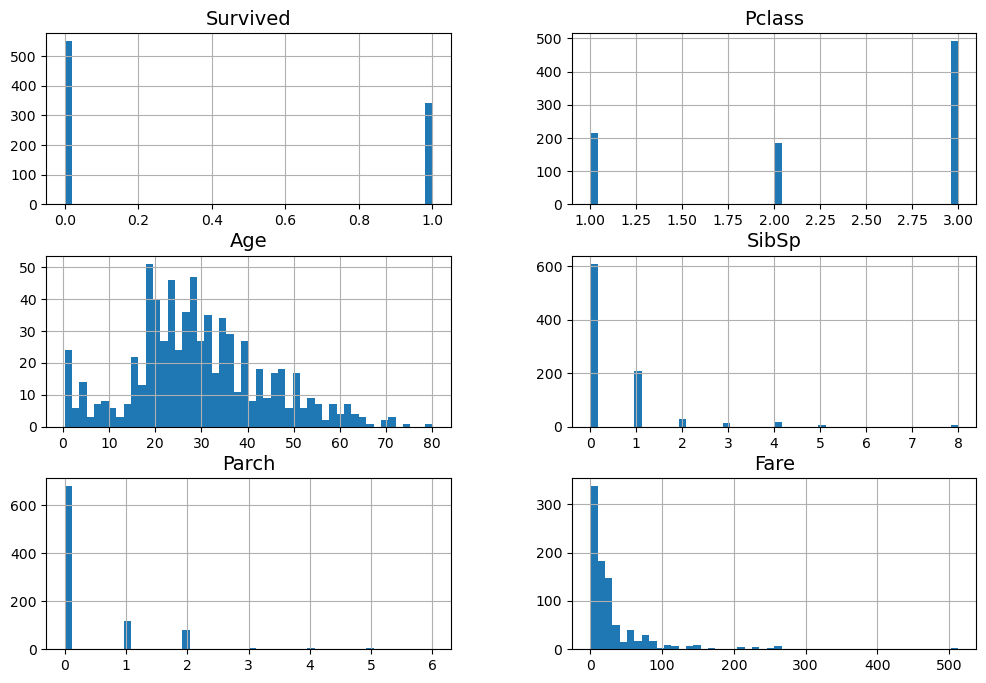

In [9]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

titanic_preprocessed.hist(bins=50, figsize=(12, 8))
#save_fig("attribute_histogram_plots")  # extra code
plt.show()

The features age, SibSp, Parch and Fare are all skewed right. They extend much farther to the right of the median than to the left. This might cause some machine learning algorithms to have trouble detecting patterns. Later we will transform these attributes to have more symmetrical and bell-shaped distributions.

# Create a Test Set

Before we dig deeper into the data now it is a good time to separate the labels an create a test set. Since there is a gender imbalance we choose to create a stratified split and separate 20% of the data with the same gender percentages.

In [10]:
import sklearn
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    titanic_preprocessed, test_size=0.2, stratify=titanic_preprocessed["Sex"], random_state=42)

In [11]:
strat_test_set["Sex"].value_counts()

male      116
female     63
Name: Sex, dtype: int64

In [12]:
strat_train_set["Sex"].value_counts()

male      461
female    251
Name: Sex, dtype: int64

As we can observe the gender ratio in both train and test sets are kept by using the stratified split.

# Explore and visualize the data to get insights

In [13]:
titanic = strat_train_set.copy()

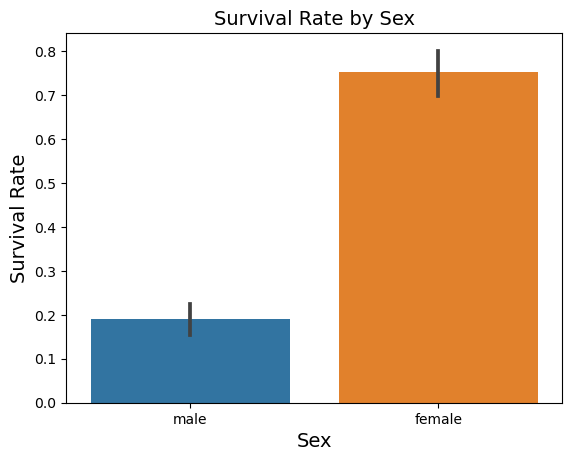

In [14]:
import seaborn as sns

# Plot a bar chart of passenger survival by sex
sns.barplot(data=titanic, x='Sex', y='Survived')
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

As we can observe the gender has a big impact in the survival rate.

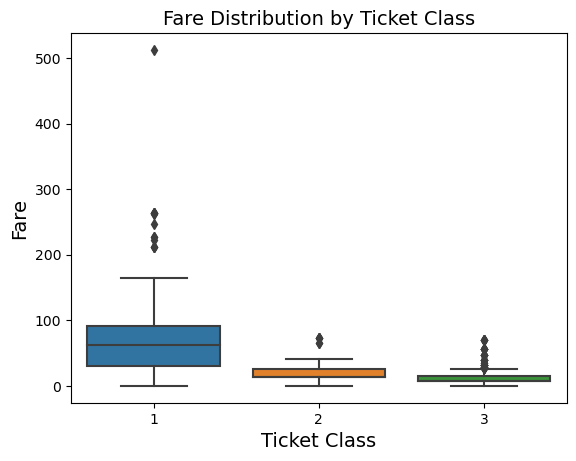

In [15]:
# Plot a boxplot of passenger fares by ticket class
sns.boxplot(data=titanic, x='Pclass', y='Fare')
plt.title('Fare Distribution by Ticket Class')
plt.xlabel('Ticket Class')
plt.ylabel('Fare')
plt.show()

As expected ticket class and passenger fare are fairly closely correlated with some outliers.

Let's now plot Survival Rate for each ticket class

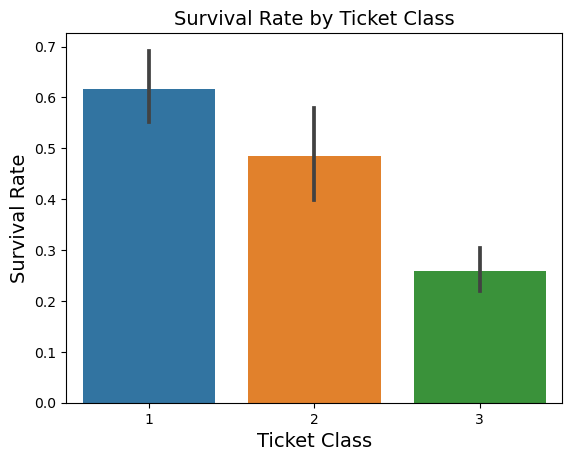

In [16]:
# Plot a bar chart of passenger survival by ticket class
sns.barplot(data=titanic, x='Pclass', y='Survived')
plt.title('Survival Rate by Ticket Class')
plt.xlabel('Ticket Class')
plt.ylabel('Survival Rate')
plt.show()

Next let's plot the "Embarked" class against survival rate:

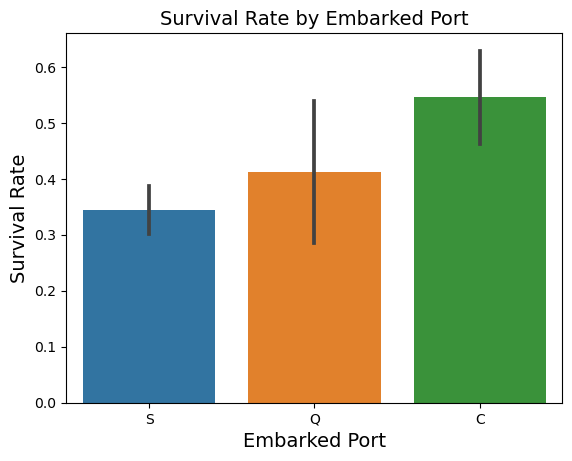

In [17]:
# Plot a bar chart of passenger survival by Embarked port
sns.barplot(data=titanic, x='Embarked', y='Survived')
plt.title('Survival Rate by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Survival Rate')
plt.show()

We do see a clear correlation with passengers embarked at Chesbourg showing the highest survival rate.

Lets create new age categories and plot the survival rate per age category.
0 - 15 Babys, toddlers and small kids
8 - 15 kids and teens
16 - 30 early adult
31- 60 adult
61+ senile

In [18]:
import numpy as np

titanic["age_cat"] = pd.cut(titanic["Age"],
                           bins=[0, 7.5, 15.5, 30.5, 60.5, np.inf],
                           labels = [1, 2, 3, 4, 5])

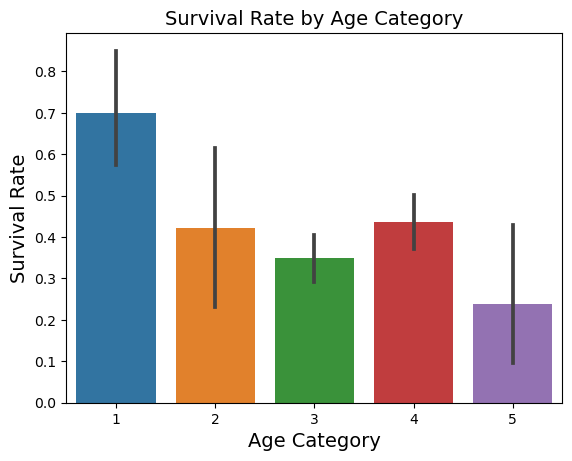

In [19]:
# Plot a bar chart of passenger survival by age category
sns.barplot(data=titanic, x='age_cat', y='Survived')
plt.title('Survival Rate by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Survival Rate')
plt.show()

From plotting the survival rate by age categories we do see a correlation. It seems infants and toddlers do have a higher survival rate while the very old do show a decrease of the survival rate compared to other adults.

Next we will assess if creating categories for the feature SibSp could be valuable. First we take a look at how values are distributed for this feature:

In [20]:
titanic["SibSp"].value_counts()

0    477
1    171
2     25
4     16
3     13
8      5
5      5
Name: SibSp, dtype: int64

Based on the values distribution we opt for the following categories for the SibSp (number of siblings/spouses) feature:
 1. Passengers with 0 siblings/spouses.
 2. Passengers with 1 sibling/spouse.
 3. Passengers with 2 or 3 siblings/spouse.
 4. Passengers with 4 or more siblings/spouse.

In [21]:
titanic["SibSp_cat"] = pd.cut(titanic["SibSp"],
                           bins=[-1, 0.5, 1.5, 3.5, np.inf],
                           labels = [1, 2, 3, 4])

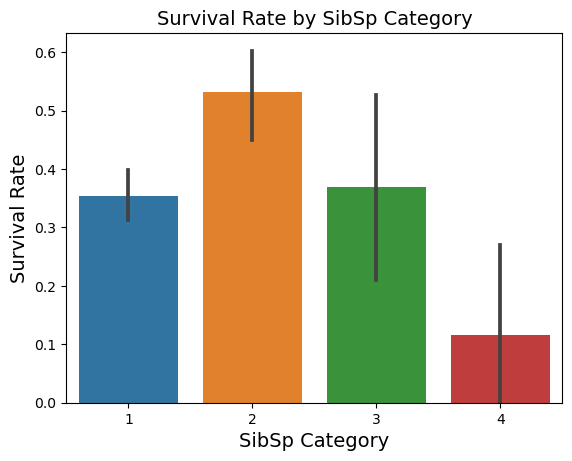

In [22]:
# Plot a bar chart of passenger survival by SibSp category
sns.barplot(data=titanic, x='SibSp_cat', y='Survived')
plt.title('Survival Rate by SibSp Category')
plt.xlabel('SibSp Category')
plt.ylabel('Survival Rate')
plt.show()

We do observe some correlation with the category with 1 sibling/spouse scoring the highest survival rate.

Next we do the same for the Parch feature:

In [23]:
titanic["Parch"].value_counts()

0    543
1     99
2     58
5      4
4      4
3      3
6      1
Name: Parch, dtype: int64

Based on the observed value distribution we opt to plot the following categories for the Parch feature (number of parents/children aboard the Titanic).
 1. Passengers with 0 parents/children.
 2. Passengers with 1 parents/children.
 3. Passengers with 2 parents/children.
 4. Passengers with 3 or more parents/children.

In [24]:
titanic["Parch_cat"] = pd.cut(titanic["Parch"],
                           bins=[-1, 0.5, 1.5, 2.5, np.inf],
                           labels = [1, 2, 3, 4])

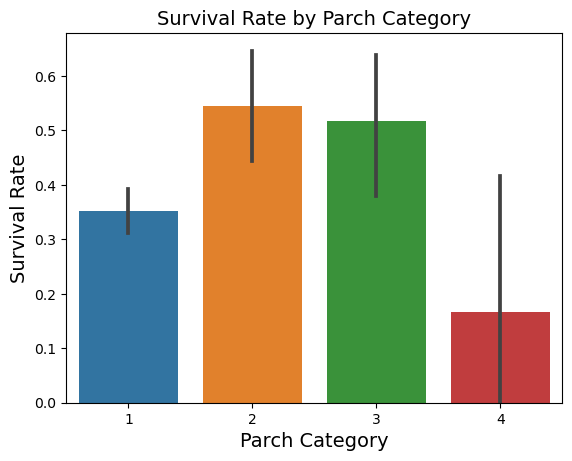

In [25]:
# Plot a bar chart of passenger survival by Parch category
sns.barplot(data=titanic, x='Parch_cat', y='Survived')
plt.title('Survival Rate by Parch Category')
plt.xlabel('Parch Category')
plt.ylabel('Survival Rate')
plt.show()

Based on the above chart it might make sense to joint categories 2 and 3 since survival rate is similar. Category number 4 shows a high std deviation but since only 12 passengers represent this category it probably does not make sense to create more categories for further differentiation.

# Looking for correlations 

In [26]:
corr_matrix = titanic.corr()

In [27]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.248255
Parch       0.059276
SibSp      -0.045019
Age        -0.075542
Pclass     -0.314577
Name: Survived, dtype: float64

It seems especially the passenger fare and ticket class show the strongest correlation with the survival rate.

Let's try to experiment with a new feature family which is the sum out of 'SibSp' and 'Parch' and look again at the correlations:

In [28]:
titanic["family"] = titanic["SibSp"] + titanic["Parch"]

In [29]:
corr_matrix = titanic.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.248255
Parch       0.059276
family     -0.001468
SibSp      -0.045019
Age        -0.075542
Pclass     -0.314577
Name: Survived, dtype: float64

It does not seem like it will improve correlation with the Survived target category, hence we won't be using it.

# Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that strat_train_set.drop() creates a copy of strat_train_set without the column, it doesn't actually modify strat_train_set itself, unless you pass inplace=True):

In [30]:
titanic = strat_train_set.drop("Survived", axis=1, inplace=False)
titanic_labels = strat_train_set["Survived"].copy()

In [31]:
titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
788,3,male,1.0,1,2,20.5750,S
347,3,female,NaN,1,0,16.1000,S
629,3,male,NaN,0,0,7.7333,Q
734,2,male,23.0,0,0,13.0000,S
106,3,female,21.0,0,0,7.6500,S


In [32]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       578 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  710 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


## Data Cleaning 

For the age class we will be replacing missing values with the median and transforming the features with a logarithmic transformation.

In [33]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')

titanic_num = titanic.select_dtypes(include=[np.number])

X = imp.fit_transform(titanic_num)

In [34]:
housing_num_clean = pd.DataFrame(X, columns=titanic_num.columns,
                          index=titanic_num.index)

In [35]:
housing_num_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  712 non-null    float64
 1   Age     712 non-null    float64
 2   SibSp   712 non-null    float64
 3   Parch   712 non-null    float64
 4   Fare    712 non-null    float64
dtypes: float64(5)
memory usage: 33.4 KB


### Age feature

Let's see how the log of the age plots:

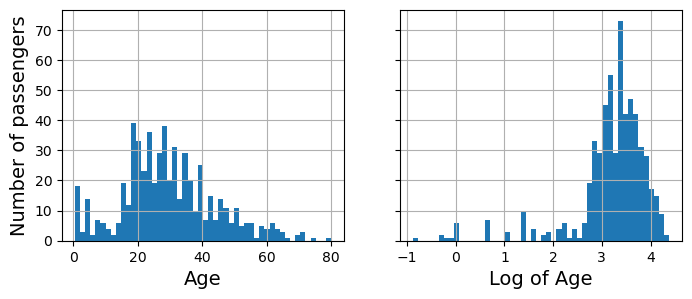

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
titanic["Age"].hist(ax=axs[0], bins=50)
titanic["Age"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Age")
axs[1].set_xlabel("Log of Age")
axs[0].set_ylabel("Number of passengers")

plt.show()

For the age feature we will be transforming this feature by the log() to reduce the heavy tail and then feature scaling with the StandardScaler() function

Later it seems that without applying the log() on the Age feature the model performs slightly better.

### Fare feature

I think the fare feature codes for similar information as the ticket class and has lower correlation than the ticket class, hence we opt to drop this feature.

### Transformation pipeline

We will be using a transformation pipeline to apply on all of the data

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler



cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))
    

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("num", default_num_pipeline, ["Fare", "Age"]),
    ],
    remainder=cat_pipeline)  # columns remaining: Embarked, Sex and Pclass

In [38]:
titanic_prepared = preprocessing.fit_transform(titanic)
titanic_prepared.shape

(712, 24)

In [39]:
preprocessing.get_feature_names_out()

array(['num__Fare', 'num__Age', 'remainder__Pclass_1',
       'remainder__Pclass_2', 'remainder__Pclass_3',
       'remainder__Sex_female', 'remainder__Sex_male',
       'remainder__SibSp_0', 'remainder__SibSp_1', 'remainder__SibSp_2',
       'remainder__SibSp_3', 'remainder__SibSp_4', 'remainder__SibSp_5',
       'remainder__SibSp_8', 'remainder__Parch_0', 'remainder__Parch_1',
       'remainder__Parch_2', 'remainder__Parch_3', 'remainder__Parch_4',
       'remainder__Parch_5', 'remainder__Parch_6',
       'remainder__Embarked_C', 'remainder__Embarked_Q',
       'remainder__Embarked_S'], dtype=object)

# Select and Train a Model

### RandomForestClassifier 

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

full_pipeline_forest = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])


y_probas_forest = cross_val_predict(full_pipeline_forest, titanic, titanic_labels, cv=5,
                                   method="predict_proba")

full_pipeline.fit(titanic, titanic_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='most_frequent')),
                                                             ('onehotencoder',
                                                              OneHotEncoder(handle_unknown='ignore'))]),
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Fare', 'Age'])])),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [41]:
y_pred_train = y_probas_forest[:,1] >= 0.5

In [42]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(titanic_labels, y_pred_train)
print("Accuracy score of the model: {:.2f}".format(accuracy))

Accuracy score of the improved model: 0.78


Now let's take a look at the feature importances:

In [43]:
feature_importances = full_pipeline_forest["random_forest"].feature_importances_
feature_importances.round(2)

array([0.25, 0.25, 0.03, 0.01, 0.05, 0.14, 0.14, 0.02, 0.02, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01,
       0.01, 0.02])

In [44]:
sorted(zip(feature_importances,
           preprocessing.get_feature_names_out()),
           reverse=True)

[(0.25099543574785, 'num__Age'),
 (0.249042288704961, 'num__Fare'),
 (0.14158646059118368, 'remainder__Sex_female'),
 (0.13504249228655105, 'remainder__Sex_male'),
 (0.048408354746462476, 'remainder__Pclass_3'),
 (0.025914873024876477, 'remainder__Pclass_1'),
 (0.018027075720899413, 'remainder__Parch_0'),
 (0.016900574595628024, 'remainder__SibSp_1'),
 (0.015764562746199418, 'remainder__Embarked_S'),
 (0.015397035765121886, 'remainder__SibSp_0'),
 (0.013814287506814567, 'remainder__Embarked_C'),
 (0.01204356018001251, 'remainder__Parch_1'),
 (0.01141800027816974, 'remainder__Pclass_2'),
 (0.010229298154202525, 'remainder__Embarked_Q'),
 (0.008768860773290043, 'remainder__Parch_2'),
 (0.00662024103387825, 'remainder__SibSp_3'),
 (0.0053782509775815055, 'remainder__SibSp_2'),
 (0.005052723683928177, 'remainder__SibSp_4'),
 (0.0024072188482197657, 'remainder__SibSp_8'),
 (0.0023556348230743436, 'remainder__Parch_5'),
 (0.0020675775519995595, 'remainder__Parch_4'),
 (0.001566295471194734, 

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression


full_pipeline_lr = Pipeline([
    ("preprocessing", preprocessing),
    ("logistic_clf", LogisticRegression(random_state=42)),
])

lr_clf = full_pipeline_lr.fit(titanic, titanic_labels)

lr_clf.score(titanic, titanic_labels)



0.8117977528089888

In [51]:
y_pred_train = lr_clf.predict(titanic)

In [52]:
accuracy = accuracy_score(titanic_labels, y_pred_train)
print("Accuracy score of the model: {:.2f}".format(accuracy))

Accuracy score of the improved model: 0.81


### SVM Classifier

In [53]:
from sklearn import svm

full_pipeline_svc = Pipeline([
    ("preprocessing", preprocessing),
    ("svc_clf", svm.SVC(random_state=42)),
])

svc_clf = full_pipeline_svc.fit(titanic, titanic_labels)

svc_clf.score(titanic, titanic_labels)

0.8356741573033708

### K-Neighbors Classifier

In [56]:
from sklearn.neighbors import KNeighborsClassifier

full_pipeline_kneigh = Pipeline([
    ("preprocessing", preprocessing),
    ("kneigh_clf", KNeighborsClassifier(n_neighbors=4)),
])

neigh_clf = full_pipeline_kneigh.fit(titanic, titanic_labels)

neigh_clf.score(titanic, titanic_labels)

0.8595505617977528

# Fine-Tuning the Models

### Fine-Tuning RandomForestClassifier 

In [71]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter space
n_estimators = [int(x) for x in np.linspace(start = 1500, stop = 2500, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, num = 11)]
max_depth.append(None)
min_samples_split = [10, 15, 20, 25, 30]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid = {
    'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_split': min_samples_split,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap
}


# Instantiate the random forest classifier
full_pipeline_forest = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])

rf_random = RandomizedSearchCV(
    full_pipeline_forest, param_distributions=random_grid, n_iter=200, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)

# Fit the model to the training data
rf_random.fit(titanic, titanic_labels)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END random_forest__bootstrap=True, random_forest__max_depth=1, random_forest__max_features=log2, random_forest__min_samples_leaf=6, random_forest__min_samples_split=15, random_forest__n_estimators=1666; total time=   1.6s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=24, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__min_samples_split=30, random_forest__n_estimators=2666; total time=   3.0s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=24, random_forest__max_features=log2, random_forest__min_samples_leaf=6, random_forest__min_samples_split=20, random_forest__n_estimators=2000; total time=   2.2s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=3, random_forest__max_features=sqrt, random_forest__min_samples_leaf=8, random_forest__min_samples_split=30, random_forest__n_estimators=2333; total time=   2.4s
[CV] END random_forest__b

[CV] END random_forest__bootstrap=True, random_forest__max_depth=3, random_forest__max_features=sqrt, random_forest__min_samples_leaf=8, random_forest__min_samples_split=30, random_forest__n_estimators=2333; total time=   2.4s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=3, random_forest__max_features=sqrt, random_forest__min_samples_leaf=8, random_forest__min_samples_split=30, random_forest__n_estimators=2333; total time=   3.0s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=None, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=25, random_forest__n_estimators=2166; total time=   2.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=9, random_forest__max_features=log2, random_forest__min_samples_leaf=4, random_forest__min_samples_split=20, random_forest__n_estimators=3000; total time=   3.0s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=None, random_forest__

[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=sqrt, random_forest__min_samples_leaf=4, random_forest__min_samples_split=10, random_forest__n_estimators=2388; total time=   3.1s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=5, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__min_samples_split=15, random_forest__n_estimators=2388; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=log2, random_forest__min_samples_leaf=4, random_forest__min_samples_split=20, random_forest__n_estimators=2055; total time=   2.6s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=log2, random_forest__min_samples_leaf=4, random_forest__min_samples_split=20, random_forest__n_estimators=2055; total time=   2.7s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_feat

[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=log2, random_forest__min_samples_leaf=4, random_forest__min_samples_split=20, random_forest__n_estimators=2055; total time=   2.6s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=20, random_forest__n_estimators=1944; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=20, random_forest__n_estimators=1944; total time=   2.5s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=11, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=20, random_forest__n_estimators=2388; total time=   2.5s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=5, random_forest__max_f

[CV] END random_forest__bootstrap=True, random_forest__max_depth=12, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=25, random_forest__n_estimators=1611; total time=   1.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=12, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=25, random_forest__n_estimators=1611; total time=   1.7s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=14, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=25, random_forest__n_estimators=1611; total time=   1.9s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=log2, random_forest__min_samples_leaf=2, random_forest__min_samples_split=25, random_forest__n_estimators=1833; total time=   2.1s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__ma

[CV] END random_forest__bootstrap=True, random_forest__max_depth=14, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=25, random_forest__n_estimators=1611; total time=   1.8s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=log2, random_forest__min_samples_leaf=2, random_forest__min_samples_split=25, random_forest__n_estimators=1833; total time=   2.2s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=11, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=15, random_forest__n_estimators=2388; total time=   2.5s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=14, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__min_samples_split=20, random_forest__n_estimators=2166; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=15, random_forest__m

[CV] END random_forest__bootstrap=False, random_forest__max_depth=12, random_forest__max_features=sqrt, random_forest__min_samples_leaf=4, random_forest__min_samples_split=20, random_forest__n_estimators=2388; total time=   2.2s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=17, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=30, random_forest__n_estimators=2388; total time=   2.8s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=5, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=25, random_forest__n_estimators=2055; total time=   2.3s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=5, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=25, random_forest__n_estimators=2055; total time=   2.2s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_

[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=sqrt, random_forest__min_samples_leaf=4, random_forest__min_samples_split=15, random_forest__n_estimators=2277; total time=   2.4s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=sqrt, random_forest__min_samples_leaf=4, random_forest__min_samples_split=15, random_forest__n_estimators=2277; total time=   2.6s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=9, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=30, random_forest__n_estimators=1833; total time=   1.9s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=8, random_forest__max_features=sqrt, random_forest__min_samples_leaf=2, random_forest__min_samples_split=30, random_forest__n_estimators=1611; total time=   1.6s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=18, random_forest__ma

[CV] END random_forest__bootstrap=True, random_forest__max_depth=11, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=15, random_forest__n_estimators=2500; total time=   3.1s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=sqrt, random_forest__min_samples_leaf=2, random_forest__min_samples_split=25, random_forest__n_estimators=2166; total time=   2.4s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10, random_forest__n_estimators=1611; total time=   1.9s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10, random_forest__n_estimators=1611; total time=   1.9s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=6, random_forest__m

[CV] END random_forest__bootstrap=False, random_forest__max_depth=6, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=10, random_forest__n_estimators=1722; total time=   1.8s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=17, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=20, random_forest__n_estimators=2500; total time=   3.4s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=17, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=20, random_forest__n_estimators=2500; total time=   3.3s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=9, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10, random_forest__n_estimators=2500; total time=   2.9s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=11, random_forest__max

[CV] END random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__min_samples_split=15, random_forest__n_estimators=2166; total time=   2.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=20, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=20, random_forest__n_estimators=2277; total time=   2.5s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=20, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=20, random_forest__n_estimators=2277; total time=   2.0s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=11, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__min_samples_split=25, random_forest__n_estimators=2166; total time=   2.1s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__ma

[CV] END random_forest__bootstrap=True, random_forest__max_depth=18, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=15, random_forest__n_estimators=2388; total time=   2.8s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=None, random_forest__max_features=sqrt, random_forest__min_samples_leaf=4, random_forest__min_samples_split=25, random_forest__n_estimators=2277; total time=   2.6s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=20, random_forest__n_estimators=2277; total time=   2.6s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=20, random_forest__n_estimators=2277; total time=   2.7s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=11, random_forest__

[CV] END random_forest__bootstrap=True, random_forest__max_depth=6, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=30, random_forest__n_estimators=2277; total time=   2.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=14, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=25, random_forest__n_estimators=2277; total time=   2.9s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=14, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=30, random_forest__n_estimators=2055; total time=   2.1s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=14, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__min_samples_split=30, random_forest__n_estimators=2055; total time=   2.1s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=17, random_forest__ma

[CV] END random_forest__bootstrap=False, random_forest__max_depth=20, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=15, random_forest__n_estimators=2500; total time=   3.1s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=6, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=30, random_forest__n_estimators=1833; total time=   1.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=6, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__min_samples_split=30, random_forest__n_estimators=1833; total time=   1.7s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=9, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10, random_forest__n_estimators=1722; total time=   2.0s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=14, random_forest__max

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler()...
                   param_distributions={'random_forest__bootstrap': [True,
                                                                     False],
                                        'random_forest__max_depth': [5, 6, 8, 9,
                                                                     11, 12, 14,
                                                                     15, 17, 18,
                                                                     20, None],
                                        'random_forest__max_features': ['log2',
                                                                        'sqrt'],
                                        'random_forest__min_samples_leaf': [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5],
                                        'random_forest__min_samples_split': [10,
                                                                             15,
                                                                             20,
                                                                             25,
                                                                             30],
                                        'random_forest__n_estimators': [1500,
                                                                        1611,
                                                                        1722,
                                                                        1833,
                                                                        1944,
                                                                        2055,
                                                                        2166,
                                                                        2277,
                                                                        2388,
                                                                        2500]},
                   random_state=42, scoring='accuracy', verbose=2)

In [73]:
# Print the best hyperparameters found
print(rf_random.best_params_)

{'random_forest__n_estimators': 2500, 'random_forest__min_samples_split': 20, 'random_forest__min_samples_leaf': 3, 'random_forest__max_features': 'sqrt', 'random_forest__max_depth': None, 'random_forest__bootstrap': False}


In [74]:
rf_random.best_estimator_.score(titanic, titanic_labels)

0.8693820224719101

[CV] END random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=10, random_forest__n_estimators=2277; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=15, random_forest__max_features=log2, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10, random_forest__n_estimators=1611; total time=   2.4s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=15, random_forest__n_estimators=2500; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=15, random_forest__n_estimators=2500; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=18, random_forest__max_fe

[CV] END random_forest__bootstrap=True, random_forest__max_depth=18, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__min_samples_split=15, random_forest__n_estimators=2277; total time=   2.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=15, random_forest__n_estimators=2388; total time=   2.8s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=8, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=15, random_forest__n_estimators=2388; total time=   2.8s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=14, random_forest__max_features=sqrt, random_forest__min_samples_leaf=3, random_forest__min_samples_split=20, random_forest__n_estimators=1833; total time=   1.6s
[CV] END random_forest__bootstrap=False, random_forest__max_depth=15, random_forest__max_

Best Random Forest Parameters found after 200 iter:

{'random_forest__n_estimators': 2500, 'random_forest__min_samples_split': 20, 'random_forest__min_samples_leaf': 3, 'random_forest__max_features': 'sqrt', 'random_forest__max_depth': None, 'random_forest__bootstrap': False}

Reached Accuracy of 86,9%


### Fine-Tuning Logistic Regressor

In [95]:
# Define the hyperparameter space
max_iter = [int(x) for x in np.linspace(start = 10, stop = 300, num = 50)]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C = [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]


random_grid = {
    'logistic_regression__solver': solver,
    'logistic_regression__max_iter': max_iter,
    'logistic_regression__C': C,
}


# Instantiate the Logistic Regressor
full_pipeline_lr = Pipeline([
    ("preprocessing", preprocessing),
    ("logistic_regression", LogisticRegression(random_state=42)),
])

lr_random = RandomizedSearchCV(
    full_pipeline_lr, param_distributions=random_grid, n_iter=5000, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)

# Fit the model to the training data
lr_random.fit(titanic, titanic_labels)


/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1800 is smaller than n_iter=5000. Running 1800 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL 

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1121, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1121, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1121, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1121, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1121, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1146, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1146, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1197, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1197, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1197, logistic_regression__solver=saga; total time=   0.1s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1197, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1248, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1248, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1248, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1248, logistic_regression__solver=ne

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1274, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1300, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=1300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression_

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=15, logistic_regression__solver=saga; total time=   0.0s
[CV

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=33, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=33, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=33, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=33, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=39, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=39, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=39, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=39, logistic_regression__solver=ne

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=51, lo

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=63, logistic_regression__solver=liblinear;

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=92, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=110, logistic_regression__solver=saga; to

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=140, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=140, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=140, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=140, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=140, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=163, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=187, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=187, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=193, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=193, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=193, logistic_regressio

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=193, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=193, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=193, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=199, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=199, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=199, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=199, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=199, logistic_regression__solver=saga; total time=   0.0s
[

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=205, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=205, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] E

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=234, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=234, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=234, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=234, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=234, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=240, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=240, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=240, logistic_reg

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to t

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=252, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=252, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=252, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=252, logistic_regression__solver=newton-cg; tot

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=258, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=258, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=258, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=264, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=264, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=264, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=264, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=264, logistic_regression__solver=lbfgs; total time=  

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/ho

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=288, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=288, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=288, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=288, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=288, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=294, logistic_regression__solver=newton

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=300, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=300, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.4, logistic_regression__max_iter=300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=10, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=10, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=10, log

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=39, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=39, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=39, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=39, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=39, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=newton-cho

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=51, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=51, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=51, logistic_regression__solver=saga; total time=   0.0s
[CV] E

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=57, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=57, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=63, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=63, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=63, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=63, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=63, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=92, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=92, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=92, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=92, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=92, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.1s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.1s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=98, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=104, logisti

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=104, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=104, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=104, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=104, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=110, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=110, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=110, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regressi

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=140, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=140, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=140, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=140, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=140, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=140, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=146, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=146, logistic_regression__solver=ne

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=152, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=152, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=152, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=152, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=157, logistic_regression__solver=liblinear; total time

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=157, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=157, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=157, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=157, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=157, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=163, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=163, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=163, logistic_regression__solver=newton

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=187, logistic_regression__solver=liblinear;

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=193, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=193, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=193, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=199, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=199, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=199, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=199, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=205, logistic_regression__solver=liblinear; total time

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs;

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=217, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=217, logistic_regression__solver=saga; total time=   0.0

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=234, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=234, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=234, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=234, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=234, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=234, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=240, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=240, logistic_regression__solver=lbfgs; total time=   0.0s

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=246, logistic_regression__solver=saga; total time=   0.0s
[CV] 

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=264, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=264, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=264, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=264, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=264, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=264, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=270, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=270, logist

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to t

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=282, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=288, logistic_regression__solver=lbfgs; total time=   

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=saga; total time=   0.1s
[CV] END logistic_regression__C=0.5, logistic_regression__max_iter=300, logistic_regression__solver=saga; total time=   0.0s
[CV

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=21, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=27, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] EN

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=39, logistic_regression__solver=sag; total t

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=57, logistic_regression__solve

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=75, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=81, logistic_regression__solve

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=86, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=86, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=92, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=92, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=92, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=92, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=92, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=92, logistic_regression__solver=liblinear;

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=104, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=104, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=104, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=104, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=104, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=104, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=110, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=110, logistic_regression__solver=lbfgs; total time=   0.0s

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=122, logistic_regression__solver=saga; total time=   0.0s
[CV

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=134, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=140, logistic_regression__solver=lbfgs; tot

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.1s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=157, logistic_regression__solver=lbfgs; total time=   

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=157, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=187, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=187, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=187, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=193, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=193, logistic

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=217, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=246, logistic_regression__solver=saga; total

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/ho

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=258, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=264, logistic_regressio

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=294, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=294, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=300, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=300, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.6, logistic_regression__max_iter=300, logistic_regression__solver=lbfgs;

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=15, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=21, logistic_regression

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=45, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=51, logistic_regre

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=63, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=69, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=69, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=69, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=69, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=69, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=69, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=75, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=75, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=75, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=75, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=75, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=75, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=81, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=81, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=81, logistic_regression__solver=lbfgs; total time=   0.0s


/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=104, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=104, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=104, logistic_regression__solver

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=116, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=116, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=122, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=122, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=122, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=122, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=122, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=122, logistic_regression__solver=ne

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=128, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=128, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=128, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=134, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=134, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=134, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=134, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=134, logistic_regression__solver=lbfgs; total tim

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=146, logistic_regression__solve

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=169, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=169, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regre

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=175, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=181, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=181, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=181, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=181, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=181, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=181, logistic_regression__solver=saga; total time=   0.0s
[CV

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=205, logistic_regressio

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=217, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=223, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=223, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=223, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=223, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=234, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=234, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=240, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=240, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=240, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=240, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=240, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=240, logistic_regressio

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=246, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=264, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=264, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=264, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=264, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=264, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=270, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=270, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=270, logistic_regression__solver=newton-cg; total ti

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/ho

[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=288, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=288, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=288, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=288, logistic_regression__solver=saga; total time=   0.1s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=288, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=294, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=294, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.7, logistic_regression__max_iter=294, logistic_regression__solver=lbfgs; total time=

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/ho

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=15, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=15, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=15, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=15, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=15, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=15, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=21, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=21, logistic_regression__solver=liblin

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=39, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=45, logistic_regression__solver=saga; total time=   0.0s
[CV] END logi

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=51, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=51, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=51, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=57, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=57, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=57, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=57, logistic_regression__solver=newton

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=92, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=98, logistic_regression_

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=110, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=110, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=110, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=116, logistic_regression__solver=saga; total time=   0

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=140, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=140, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=146, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=146, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=146, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=146, logistic_regression__solver=saga; total time=   0.0s
[CV

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=152, logistic_regression__solver=saga; tota

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=193, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=193, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=199, logistic_regressio

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=211, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=211, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=211, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=211, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=217, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=246, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=liblinear; tot

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/ho

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=252, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=258, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=258, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=258, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=258, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=258, logistic_regression__solver=n

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to t

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/ho

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=294, logistic_regression__solver=saga; total

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=0.8, logistic_regression__max_iter=300, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=10, logistic_regression__solver=sag; total time=   0

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=45, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=45, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=51, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=51, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=51, logistic_regre

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=57, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=63, logistic_regression__solver=sag; total time=   0.0s
[CV] END logi

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=92, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=92, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=98, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=98, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=98, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=98, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=98, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=98, logistic_regression__solver=saga; total time=   0.0s
[CV] E

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=110, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=116, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=116, logistic_regression__solver=liblinear; total time=

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=lbfg

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=152, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=saga; total time=   0.0s
[CV

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=157, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=163, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=163, logistic_regression__solver=liblinear; total time=

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=199, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=newton-cholesky; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=205, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=211, logistic_regression__solver=lbfgs; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=211, logistic_r

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=217, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=217, logistic_regression__solver=saga; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=223, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=223, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=223, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=223, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=223, logistic_regression__solver=sag; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=223, logistic_regression__solver=saga; total time=   0.0s
[CV] E

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=liblinear; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=246, logistic_regression__solver=newton-cg; total time=   0.0s
[CV] END logistic_regression__C=1.0, logistic_regression__max_iter=252, logistic_regressio

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1500 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/igolas0/Programs/anaco

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler()...
                   param_distributions={'logistic_regression__C': [0.4, 0.5,
                                                                   0.6, 0.7,
                                                                   0.8, 1.0],
                                        'logistic_regression__max_iter': [10,
                                                                          15,
                                                                          21,
                                                                          27,
                                                                          33,
                                                                          39,
                                                                          45,
                                                                          51,
                                                                          57,
                                                                          63,
                                                                          69,
                                                                          75,
                                                                          81,
                                                                          86,
                                                                          92,
                                                                          98,
                                                                          104,
                                                                          110,
                                                                          116,
                                                                          122,
                                                                          128,
                                                                          134,
                                                                          140,
                                                                          146,
                                                                          152,
                                                                          157,
                                                                          163,
                                                                          169,
                                                                          175,
                                                                          181, ...],
                                        'logistic_regression__solver': ['lbfgs',
                                                                        'liblinear',
                                                                        'newton-cg',
                          

In [96]:
# Print the best hyperparameters found
print(lr_random.best_params_)

{'logistic_regression__solver': 'lbfgs', 'logistic_regression__max_iter': 15, 'logistic_regression__C': 0.4}


Best logistic regression parameters found after 5000 iterations

{'logistic_regression__solver': 'lbfgs', 'logistic_regression__max_iter': 15, 'logistic_regression__C': 0.4}

Reaches 81,2% Accuracy

In [97]:
lr_random.best_estimator_.score(titanic, titanic_labels)

0.8117977528089888

### Fine-Tuning SVM Classifier

In [109]:
# Define the hyperparameter space
#kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'] #best kernel found is poly. now searching degree
C = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
degree= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

random_grid = {
    #'svc_clf__kernel': kernel,
    'svc_clf__degree': degree,
    'svc_clf__C': C,
}


# Instantiate the SVM Classifier and preprocessing pipeline
full_pipeline_svc = Pipeline([
    ("preprocessing", preprocessing),
    ("svc_clf", svm.SVC(random_state=42, kernel='poly')),
])

svc_random = RandomizedSearchCV(
    full_pipeline_svc, param_distributions=random_grid, n_iter=5000, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)

# Fit the model to the training data
svc_random.fit(titanic, titanic_labels)


/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 90 is smaller than n_iter=5000. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=8; total time=   0.0s
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=8; total time=   0.0s
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=8; total time=   0.0s
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=9; total time=   0.0s
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=9; total time=   0.0s
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=9; total time=   0.0s
[CV] END ..................svc_clf__C=0.3, svc_clf__degree=9; total time=   0.0s
[CV] END ..................svc_clf__C=0.4, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.4, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.4, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.4, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.4, svc_

[CV] END ..................svc_clf__C=0.7, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.7, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.7, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.7, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.7, svc_clf__degree=9; total time=   0.0s
[CV] END .................svc_clf__C=0.7, svc_clf__degree=10; total time=   0.0s
[CV] END .................svc_clf__C=0.7, svc_clf__degree=10; total time=   0.0s
[CV] END .................svc_clf__C=0.7, svc_clf__degree=10; total time=   0.0s
[CV] END .................svc_clf__C=0.7, svc_clf__degree=10; total time=   0.0s
[CV] END .................svc_clf__C=0.7, svc_clf__degree=10; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=1; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=1; total time=   0.0s
[CV] END ..................s

[CV] END ..................svc_clf__C=0.7, svc_clf__degree=8; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=3; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=4; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=9; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=9; total time=   0.0s
[CV] END ..................svc_clf__C=0.8, svc_clf__degree=9; total time=   0.0s
[CV] END .................sv

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Fare',
                                                                                'Age'])])),
                                             ('svc_clf',
                                              SVC(kernel='poly',
                                                  random_state=42))]),
                   n_iter=5000, n_jobs=-1,
                   param_distributions={'svc_clf__C': [0.1, 0.15, 0.2, 0.25,
                                                       0.3, 0.35, 0.4, 0.45,
                                                       0.5],
                                        'svc_clf__degree': [1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10]},
                   random_state=42, scoring='accuracy', verbose=2)

In [110]:
# Print the best hyperparameters found
print(svc_random.best_params_)

{'svc_clf__degree': 4, 'svc_clf__C': 0.2}


In [111]:
svc_random.best_estimator_.score(titanic, titanic_labels)

0.8412921348314607

Best SVC hyperparameters found after 5000 iterations:

{'svc_clf__degree': 4, 'svc_clf__C': 0.2} with 'poly' kernel

Reaches 84,1% Accuracy

### Fine-Tuning KNeighbors Classifier

In [116]:
# Define the hyperparameter space
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] 
weights = ['uniform', 'distance']
weights.append(None)
n_neighbors = [3, 4, 5, 6, 7, 8]

random_grid = {
    'kneigh_clf__algorithm': algorithm,
    'kneigh_clf__n_neighbors': n_neighbors,
    'kneigh_clf__weights': weights,
}


# Instantiate the KNeighbors Classifier and preprocessing pipeline
full_pipeline_kneigh = Pipeline([
    ("preprocessing", preprocessing),
    ("kneigh_clf", KNeighborsClassifier()),
])

kneigh_random = RandomizedSearchCV(
    full_pipeline_kneigh, param_distributions=random_grid, n_iter=1000, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)

# Fit the model to the training data
kneigh_random.fit(titanic, titanic_labels)


/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 72 is smaller than n_iter=1000. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaco

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaco

[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=4, kneigh_clf__weights=uniform; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=4, kneigh_clf__weights=uniform; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=4, kneigh_clf__weights=uniform; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=5, kneigh_clf__weights=uniform; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=5, kneigh_clf__weights=distance; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=5, kneigh_clf__weights=distance; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=5, kneigh_clf__weights=distance; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=5, kneigh_clf__weights=distance; total time=   0.0s
[CV] END kneigh_clf__algorithm=brute, kneigh_clf__n_neighbors=5, kneigh_clf__weights=distanc

/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/igolas0/Programs/anaco

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Fare',
                                                                                'Age'])])),
                                             ('kneigh_clf',
                                              KNeighborsClassifier())]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'kneigh_clf__algorithm': ['auto',
                                                                  'ball_tree',
                                                                  'kd_tree',
                                                                  'brute'],
                                        'kneigh_clf__n_neighbors': [3, 4, 5, 6,
                                                                    7, 8],
                                        'kneigh_clf__weights': ['uniform',
                                                                'distance',
                                                                None]},
                   random_state=42, scoring='accuracy', verbose=2)

In [117]:
print(kneigh_random.best_params_)

{'kneigh_clf__weights': 'uniform', 'kneigh_clf__n_neighbors': 5, 'kneigh_clf__algorithm': 'auto'}


In [118]:
kneigh_random.best_estimator_.score(titanic, titanic_labels)

0.8651685393258427

Best KNeighbors Classifier hyperparameters found after 1000 iterations:

{'kneigh_clf__weights': 'uniform', 'kneigh_clf__n_neighbors': 5, 'kneigh_clf__algorithm': 'auto'}

Reaches 86,5% Accuracy